# Find a plane Couette equilibrium with CloudAtlas.jl

2025-10-29. Produce data for ODE convergence plot for PRL.  
2025-11-03. Revised to work with CloudAtlas package 

  1. Construct an low-d ODE model for a symmetric subspace of plane Couette flow, 
  using Galerkin projection onto finite basis that incorporates the 
  boundary conditions & incompressibility constraint and spans a specified symmetric
  subspace of the flow. 
  2. Search for an equilibrium in the ODE. Use the projection of the Nagata
upper-equilibrium onto the basis for the initial guess.
  3. Compute the eigenvalues of the ODE equilibrium and compare to those from DNS.

## 0. Preliminaries

Load some packages and define a few functions. 

In [1]:
using LinearAlgebra, Polynomials, Plots
using Revise, DelimitedFiles, BenchmarkTools

using CloudAtlas

display("text/html", "<style>.container { width:100% !important; }</style>")

"""
    myreaddlm(filename, cc='%')

Read matrix or vector from a file, dropping comments marked with cc.
"""
function myreaddlm(filename, cc='%')
    X = readdlm(filename, comments=true, comment_char=cc)
    if size(X,2) == 1
        X = X[:,1]
    end
    X
end

# handy symmetry definitions
id = Symmetry()
sx = Symmetry(-1,1,1)
sy = Symmetry(1,-1,1)
sz = Symmetry(1,1,-1)
tx = Symmetry(1,1,1, 1//2, 0//1)
tz = Symmetry(1,1,1, 0//1, 1//2)

pwd()

"/home/gibson/research/algebraic-eqbs"

## 1. Construct an ODE model of plane Couette flow

Construct a set of divergence-free, periodic/no-slip basis functions $\bf{\Psi}$
for expanding a velocity field, ${\bf u}({\bf x},t) = \sum_{i=1^m} x_i(t) {\bf \Psi}({\bf x})$.
Here ${\bf u}$ is the fluctuating velocity; the total velocity field is the sum of laminar
flow and the fluctuation, ${\bf u}_{tot}({\bf x},t) = y \, {\bf e}_x + {\bf u}({\bf x},t)$.

Then construct ODE model of plane Couette flow $B dx/dt = (A_1 + R^{-1} A_2) x + N(x)$ where
$B, A_1, A_2,$ and $N$ are determined by Galerkin projection of the plane Couette 
Navier-Stokes equations onto the basis. $A_1$ represents the The return values of `ODEModel` are functions
$f(x,R) = B^{-1} (A_1 + R^{-1} A_2) x + N(x)$ and $Df(x,R) = [\partial f_i/\partial x_j]$

In [2]:
α, γ = 1.0, 2.0                     # Fourier wavenumbers α, γ = 2π/Lx, 2π/Lz
J,K,L = 1,1,3                       # Bounds on Fourier modes (J,K) and wall-normal polynomials (L)

H = [sx*sy*sz, sz*tx*tz]            # Generators of the symmetric subspace of the Nagata eqb

@time ijkl = basisIndices(J,K,L, H) # Compute index set of H-symmetric basis elements Ψijkl
@time Ψ = basisSet(α, γ, ijkl)      # Compute basis elements Ψijkl in the index set
@time f, Df = ODEModel(Ψ);          # Do Galerkin projection, return f(x,R) for ODE dx/dt = f(x,R)

@show Nmodes = length(Ψ)

  0.721472 seconds (1.51 M allocations: 71.384 MiB, 3.25% gc time, 99.99% compilation time)
  1.803612 seconds (3.73 M allocations: 182.487 MiB, 1.53% gc time, 99.94% compilation time)
Making matrices B,A1,A2,S3...
Making quadratic operator N...
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
  1.787334 seconds (2.62 M allocations: 123.783 MiB, 1.41% gc time, 98.16% compilation time)
Nmodes = length(Ψ) = 17


17

Look at the first few basis functions. 

In [3]:
for n in 1:5
    println("Ψ$(ijkl[n,:]) = $(psistr(Ψ[n]))")
end

Ψ[1, 0, 0, 1] = [  (+1) (+1) (+1) (-4.0*y + 4.0*y^3)) ; 0 ; 0 ]
Ψ[1, 0, 0, 3] = [  (+1) (+1) (+1) (5.0*y - 14.0*y^3 + 9.0*y^5)) ; 0 ; 0 ]
Ψ[1, 0, 1, 0] = [  (+1) (+1) (+1) sin(γz) (1.0 - 1.0*y^2)) ; 0 ; 0 ]
Ψ[1, 0, 1, 2] = [  (+1) (+1) (+1) sin(γz) (1.0 - 6.0*y^2 + 5.0*y^4)) ; 0 ; 0 ]
Ψ[2, 0, 1, 1] = [  0 ; (2.0) (+1) (+1) sin(γz) (1.0 - 2.0*y^2 + 1.0*y^4)) ; (+1) (+1) (+1) cos(γz) (-4.0*y + 4.0*y^3)) ]


Verify that $x=0$ is a solution (the laminar solution) of $f(x,R)$ by showing 
$\|f(0,400)\| = 0$.

In [4]:
x = zeros(Nmodes)
norm(f(x, 400))

0.0

## Solve for eqb using hookstep

First produce an initial guess for the ODE equilibrium by projecting a DNS equilibrium onto 
the basis using a channelflow program. Save the projected basis coefficients into data file.

In [5]:
; projectfield indices/ijkl-sxyz-sztxz-1-1-3-17d.asc flowfields/EQ2Re200-48x49x48 eq2re200-1-1-3

alpha, gamma == 1, 2
Nx, Ny, Nz == 48, 49, 48
Reading ijkl indices of basis set from file
reading N == 17 ijkl indices
ijkl[0] == 1 0 0 1
L == max l == 3
Constructing Legendre polynomials
Constructing S, and Sprime polynomials
Generating psi[i]...
Computing innerproduct of u onto psi[1] to psi[17] ...
Computing inner product matrix...
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 
Solving for coefficients of u in psi basis...Saving expansion to file...Expanding projected field...
L2Norm(u)      == 0.3468849289652908
L2Norm(uout)   == 0.3396118806641006
L2Dist(u,uout) == 0.07066062874789356
L2Dist(u,uout)/L2Norm(u) == 0.2037004863793429


Load the data file into channel flow. EQ2 is the Nagata upper-branch equilibrium.

In [6]:
n = 2    # EQn
R = 200  # Reynolds number

datafile = "convergence/eq$(n)/xeq$(n)re$(R)-$J-$K-$L.asc"
@show datafile

xguess = myreaddlm(datafile)

datafile = "convergence/eq2/xeq2re200-1-1-3.asc"


17-element Vector{Float64}:
  0.23260373288592556
 -0.021574004626809425
  0.3600774728488724
 -0.15003898280071293
 -0.04390915158549901
  0.01692621675102676
 -0.03988543745406466
  0.020578334239183135
 -0.06558443405097515
  0.007844888490996375
 -0.02145288743785215
 -0.06861242491510545
 -0.05510721851204111
 -0.033943918156845464
 -0.01907854982720552
  0.016978923729754212
  0.028871465532554104

If that data is unavailable, use this guess (uncomment the code). 

In [7]:
# xguess = [0.23; -0.02; 0.36; -0.15; -0.04; 0.017; -0.04; 0.02; 
#     -0.07; 0.008; -0.02; -0.07; -0.06; -0.03; -0.02; 0.02; 0.03]

Newton-hookstep search for equilibrium solution of the ODE $dx/dt = f(x)$ using EQ2 projection as initial guess.

In [8]:
fᵣ = x -> f(x,R)    # define function fᵣ(x) = f(x,R)   for fixed R
Dfᵣ = x -> Df(x,R)  # define function Dfᵣ(x) = Df(x,R) for fixed R

@time xsoln, success = hookstepsolve(fᵣ, Dfᵣ, xguess, ftol=1e-08, xtol=1e-12, Nnewton=30,Nhook=8,verbosity=0)

@show norm(fᵣ(xsoln))/norm(xsoln)
@show norm(xsoln)
@show success;

  1.296519 seconds (2.16 M allocations: 106.011 MiB, 1.94% gc time, 99.73% compilation time)
norm(fᵣ(xsoln)) / norm(xsoln) = 1.18889283132257e-12
norm(xsoln) = 0.5383294866000925
success = true


In [9]:
xsoln

17-element Vector{Float64}:
  0.16764501297872597
 -0.018552429184450946
  0.4864080003106776
 -0.09759477658299559
 -0.034119864670893965
 -0.010665050873274864
 -0.017317132771592334
  0.02011331750456491
 -0.03572908824853327
 -0.008809478659136059
 -0.018431734694114302
 -0.04736482534041838
 -0.04609045288651892
 -0.03157916691991225
  0.0010374375710159654
  0.016019576847790745
  0.07702704665990354

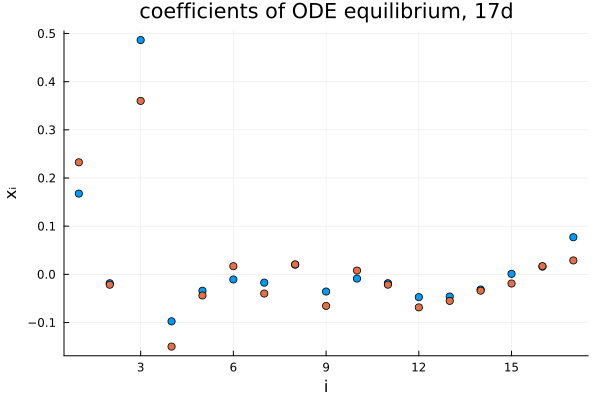

In [10]:
using Plots

scatter(1:Nmodes, xsoln, label="x solution")
scatter!(1:Nmodes, xguess, label="x guess")
plot!(xlabel="i", ylabel="xᵢ", legend=:none, title="coefficients of ODE equilibrium, $(Nmodes)d")

The likeness of ODE equilibrium (x solution) to projection of the Nagata solution
(x guess) means these two points are nearby in the low-d symmetric subspace.
The ODE equilibrium represents a rough force balance among the fundamental 
Fourier-polynomial modes very similar to the same modes in a highly-resolved
DNS computation. 

### Compare eigenvalues to DNS

Read DNS eigenvalues computed with channelflow from disk.

In [11]:
λDNS = myreaddlm("eigenvalues/EQ2Re200-48x49x48/lambda.asc", '%')
λDNS = λDNS[:,1] + im*λDNS[:,2]  # convert from a,b to a+ib
λDNS[1:10]

10-element Vector{ComplexF64}:
  0.026707737535753874 - 0.12632656961181893im
  0.026707737535753874 + 0.12632656961181893im
 -0.036413058754869936 - 0.05369967545974955im
 -0.036413058754869936 + 0.05369967545974955im
   -0.0582157644474926 - 0.30777163366872934im
   -0.0582157644474926 + 0.30777163366872934im
   -0.1065151660426499 + 0.06627646627373736im
   -0.1065151660426499 - 0.06627646627373736im
   -0.1408290059468807 + 0.2759955540455185im
   -0.1408290059468807 - 0.2759955540455185im

In [12]:
@time λODE = sort(eigvals(Dfᵣ(xsoln)), by = λ -> real(λ), rev=:true)
λODE[1:10]

  0.414796 seconds (388.13 k allocations: 19.331 MiB, 99.86% compilation time)


10-element Vector{ComplexF64}:
  0.09395778499885118 - 0.16380273531902034im
  0.09395778499885118 + 0.16380273531902034im
  0.04460084133209358 + 0.0im
 0.024120522659495845 - 0.5786157602508053im
 0.024120522659495845 + 0.5786157602508053im
 -0.05122501326818991 + 0.0im
 -0.13041119070355417 - 0.17266433726200608im
 -0.13041119070355417 + 0.17266433726200608im
 -0.16183109506507837 - 0.3083313341728836im
 -0.16183109506507837 + 0.3083313341728836im

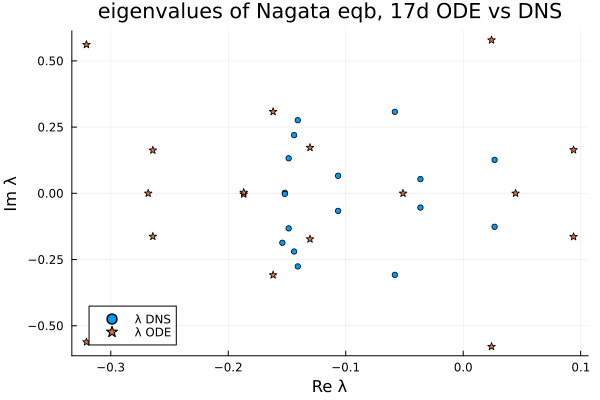

In [13]:
n=17
scatter(λDNS[1:n], markersize=3, markershape=:circ, label="λ DNS")
scatter!(λODE[1:n], markersize=4, markershape=:star, label="λ ODE")
plot!(xlabel = "Re λ", ylabel="Im λ", legend=:bottomleft)
plot!(title="eigenvalues of Nagata eqb, $(Nmodes)d ODE vs DNS")

No great accuracy in the eigenvalues. The number of unstable eigenvalues is wrong, but
they are complex, and there is rough correspondence in overall structure (magnitude, 
many stable, few unstable). 

## Redo calculations for finer discretization, higher ODE dimension

Consolidate all the calculations to a few blocks of code.

  0.000051 seconds (794 allocations: 53.406 KiB)
  0.000175 seconds (1.19 k allocations: 55.148 KiB)
Making matrices B,A1,A2,S3...
Making quadratic operator N...
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 
  3.839367 seconds (24.56 M allocations: 554.123 MiB, 9.81% gc time)
Nmodes = length(Ψ) = 97
datafile = "convergence/eq2/xeq2re200-2-3-5.asc"
  0.306633 seconds (4.19 M allocations: 77.334 MiB, 4.92% gc time, 50.38% compilation time)
norm(fᵣ(xsoln)) = 1.1527498308369668e-11
norm(xsoln) = 0.4727230541927328
success = true


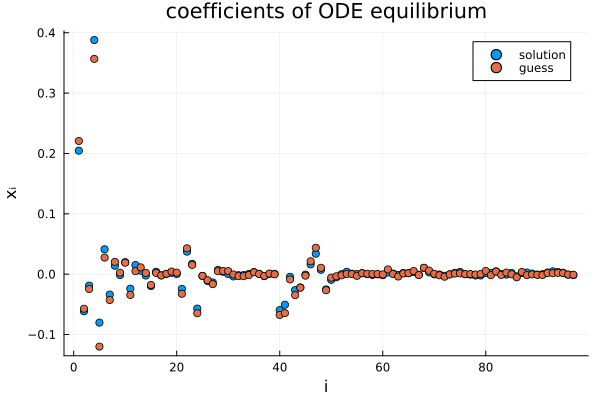

In [14]:
α, γ = 1.0, 2.0                     # Fourier wavenumbers α, γ = 2π/Lx, 2π/Lz
J,K,L = 2,3,5                       # Bounds on fourier modes (J,K) and wall-normal polynomials L

H = [sx*sy*sz, sz*tx*tz]            # The generators of the symmetric subspace 

@time ijkl = basisIndices(J,K,L, H) # Compute index set of H-symmetric basis elements Ψijkl
@time Ψ = basisSet(α, γ, ijkl)      # Compute basis elements Ψijkl in the index set
@time f, Df = ODEModel(Ψ);          # Do Galerkin projection, return f(x,R) for ODE dx/dt = f(x,R)

@show Nmodes = length(Ψ)

n = 2    # EQn
R = 200  # Reynolds number

datafile = "convergence/eq$(n)/xeq$(n)re$(R)-$J-$K-$L.asc"
@show datafile

xguess = myreaddlm(datafile)
fᵣ = x -> f(x,R)                    # define function fᵣ(x) = f(x,R)   for fixed R
Dfᵣ = x -> Df(x,R)                  # define function Dfᵣ(x) = Df(x,R) for fixed R

@time xsoln, success = hookstepsolve(fᵣ, Dfᵣ, xguess, ftol=1e-08, xtol=1e-12, Nnewton=30,Nhook=8,verbosity=0)

@show norm(fᵣ(xsoln))
@show norm(xsoln)
@show success;

scatter(1:Nmodes, xsoln, label="solution")
scatter!(1:Nmodes, xguess, label="guess")
plot!(xlabel="i", ylabel="xᵢ", title="coefficients of ODE equilibrium")

  0.421096 seconds (695.13 k allocations: 24.175 MiB, 96.84% compilation time)


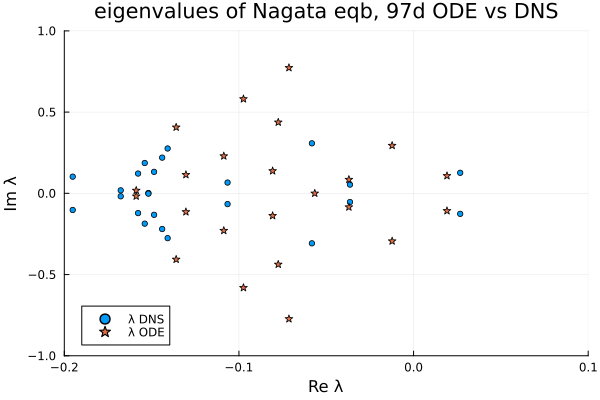

In [15]:
@time λODE = sort(eigvals(Dfᵣ(xsoln)), by = λ -> real(λ), rev=:true)

n = 25

scatter(λDNS[1:n], markersize=3, markershape=:circ, label="λ DNS")
scatter!(λODE[1:n], markersize=4, markershape=:star, label="λ ODE")
plot!(xlabel = "Re λ", ylabel="Im λ", legend=:bottomleft)
plot!(title="eigenvalues of Nagata eqb, $(Nmodes)d ODE vs DNS")
plot!(xlim=(-0.2, 0.1), ylim=(-1,1))

In [16]:
λODE[1:10]

10-element Vector{ComplexF64}:
  0.019137190108152256 - 0.10778022800095265im
  0.019137190108152256 + 0.10778022800095265im
 -0.012269358107352295 - 0.29411405250662953im
 -0.012269358107352295 + 0.29411405250662953im
  -0.03703034213107512 - 0.08476854682327015im
  -0.03703034213107512 + 0.08476854682327015im
   -0.0565771448680579 + 0.0im
  -0.07135853977934578 - 0.7729342124876596im
  -0.07135853977934578 + 0.7729342124876596im
  -0.07748435580024059 - 0.43734214322140225im

In [17]:
λDNS[1:10]

10-element Vector{ComplexF64}:
  0.026707737535753874 - 0.12632656961181893im
  0.026707737535753874 + 0.12632656961181893im
 -0.036413058754869936 - 0.05369967545974955im
 -0.036413058754869936 + 0.05369967545974955im
   -0.0582157644474926 - 0.30777163366872934im
   -0.0582157644474926 + 0.30777163366872934im
   -0.1065151660426499 + 0.06627646627373736im
   -0.1065151660426499 - 0.06627646627373736im
   -0.1408290059468807 + 0.2759955540455185im
   -0.1408290059468807 - 0.2759955540455185im

The leading eigenvalues of the 97-mode model are roughly accurate.
The period of oscillation of the leading complex eigenvalue is

In [18]:
@show Tode = 2pi/0.108
@show Tdns = 2pi/0.126 

Tode = (2pi) / 0.108 = 58.17764173314432
Tdns = (2pi) / 0.126 = 49.86655005698084


49.86655005698084